# Data pre-processing

In [10]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [11]:
# Load the data from the uploaded CSV file
file_path = "/content/combined_mutation_CNV.csv"
data = pd.read_csv(file_path)

# Separate the features and labels
labels = data["Subtype"].values
features = data.drop(columns=["Subtype", "Sample"]).values

# Convert to numpy arrays
labels = np.array(labels)
labels[labels=='PDM'] = 0
labels[labels=='SCM'] = 1

features = np.array(features)

# Output the results
print("Labels:", labels.shape)
print("Features:", features.shape)


Labels: (43,)
Features: (43, 656)


In [12]:
# Create a MinMaxScaler object with a feature range of -1 to 1
min_max_Scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Fit the MinMaxScaler to the data (excluding the last column) and transform the data
# This scales the features to the specified range (-1 to 1)
features = min_max_Scalar.fit_transform(features)

# Convert the transformed data to a NumPy array
features = np.asarray(features)

# Encode labels if they are not integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# PSO

In [1]:
from numpy.random import rand

import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Error rate calculation
def error_rate(x, opts, model):
    fold = opts["fold"]
    xt, yt, xv, yv = fold["xt"], fold["yt"], fold["xv"], fold["yv"]

    num_train, num_valid = xt.shape[0], xv.shape[0]
    xtrain_selected = xt[:, x == 1]
    ytrain_reshaped = yt.reshape(num_train)
    xvalid_selected = xv[:, x == 1]
    yvalid_reshaped = yv.reshape(num_valid)

    mdl = model()

    mdl.fit(xtrain_selected, ytrain_reshaped)
    ypred = mdl.predict(xvalid_selected)
    accuracy = np.sum(yvalid_reshaped == ypred) / num_valid
    return 1 - accuracy


# Cost function combining error rate and feature size
def Fun(x, opts, model):
    alpha = 0.99
    beta = 1 - alpha
    max_feat = len(x)
    num_feat = np.sum(x == 1)

    if num_feat == 0:
        return 1

    error = error_rate(x, opts, model)
    return alpha * error + beta * (num_feat / max_feat)


# Plotting the convergence curve
def plot_convergence(curve, max_iter):
    x = np.arange(1, max_iter + 1)
    plt.plot(x, curve, "o-")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Fitness")
    plt.title("PSO")
    plt.grid()
    plt.show()


# Initialize particle positions
def init_position(lb, ub, N, dim):
    return lb + (ub - lb) * rand(N, dim)


# Initialize particle velocities
def init_velocity(lb, ub, N, dim):
    Vmax = (ub - lb) / 2
    Vmin = -Vmax
    V = Vmin + (Vmax - Vmin) * rand(N, dim)
    return V, Vmax, Vmin


# Binary conversion of positions
def binary_conversion(X, thres, N, dim):
    return (X > thres).astype(int)


# Ensure boundaries are respected
def boundary(x, lb, ub):
    return np.clip(x, lb, ub)


# Particle Swarm Optimization for feature selection
def pso_jfs(xtrain, ytrain, opts, model):
    ub, lb = 1, 0
    thres, w, c1, c2 = 0.5, 0.9, 2, 2

    N, max_iter = opts["N"], opts["T"]
    w = opts.get("w", w)
    c1 = opts.get("c1", c1)
    c2 = opts.get("c2", c2)

    dim = xtrain.shape[1]
    lb = np.full(dim, lb)
    ub = np.full(dim, ub)

    X = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim)
    fit = np.full(N, np.inf)
    Xgb = np.zeros(dim)
    fitG = np.inf
    Xpb = X.copy()
    fitP = np.full(N, np.inf)
    curve = np.zeros(max_iter)

    for t in range(max_iter):
        Xbin = binary_conversion(X, thres, N, dim)

        for i in range(N):
            fit[i] = Fun(Xbin[i], opts, model)
            if fit[i] < fitP[i]:
                Xpb[i] = X[i]
                fitP[i] = fit[i]
            if fitP[i] < fitG:
                Xgb = Xpb[i]
                fitG = fitP[i]

        curve[t] = fitG
        print(f"Iteration: {t+1}, Best (PSO): {curve[t]}")

        for i in range(N):
            for d in range(dim):
                r1, r2 = rand(), rand()
                V[i, d] = (
                    w * V[i, d]
                    + c1 * r1 * (Xpb[i, d] - X[i, d])
                    + c2 * r2 * (Xgb[d] - X[i, d])
                )
                V[i, d] = boundary(V[i, d], Vmin[d], Vmax[d])
                X[i, d] += V[i, d]
                X[i, d] = boundary(X[i, d], lb[d], ub[d])

    Gbin = binary_conversion(Xgb.reshape(1, -1), thres, 1, dim).flatten()
    selected_features = np.where(Gbin == 1)[0]

    return {"sf": selected_features, "c": curve, "nf": len(selected_features)}


# Helper Functions

In [14]:
import json

import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

In [18]:
def encode_labels(labels):
    """Encode labels if they are not integers."""
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(labels)

def perform_k_fold_cv(features, labels_encoded, best_params, model):
    """Perform k-fold cross-validation with the best parameters and return results."""
    skf = StratifiedKFold(n_splits=5)
    accuracies = []
    all_classification_reports = []
    all_confusion_matrices = []

    for train_index, test_index in skf.split(features, labels_encoded):
        x_train_fold, x_test_fold = features[train_index], features[test_index]
        y_train_fold, y_test_fold = (
            labels_encoded[train_index],
            labels_encoded[test_index],
        )

        model_fold = model(**best_params)
        model_fold.fit(x_train_fold, y_train_fold)

        y_pred_fold = model_fold.predict(x_test_fold)
        accuracy_fold = metrics.accuracy_score(y_test_fold, y_pred_fold) * 100
        accuracies.append(accuracy_fold)

        classification_report_fold = classification_report(
            y_test_fold, y_pred_fold, output_dict=True
        )
        all_classification_reports.append(classification_report_fold)

        confusion_matrix_fold = confusion_matrix(y_test_fold, y_pred_fold)
        all_confusion_matrices.append(confusion_matrix_fold)

    return accuracies, all_classification_reports, all_confusion_matrices


def compute_average_classification_report(all_classification_reports):
    """Compute the average classification report."""
    return {
        key: {
            "precision": np.mean(
                [cr[key]["precision"] for cr in all_classification_reports]
            ),
            "recall": np.mean([cr[key]["recall"] for cr in all_classification_reports]),
            "f1-score": np.mean(
                [cr[key]["f1-score"] for cr in all_classification_reports]
            ),
            "support": np.mean(
                [cr[key]["support"] for cr in all_classification_reports]
            ),
        }
        for key in all_classification_reports[0].keys()
        if key != "accuracy"
    }


def plot_average_classification_report(average_classification_report):
    """Plot the average classification report."""
    categories = list(average_classification_report.keys())
    precision = [average_classification_report[cat]["precision"] for cat in categories]
    recall = [average_classification_report[cat]["recall"] for cat in categories]
    f1_score = [average_classification_report[cat]["f1-score"] for cat in categories]

    x = np.arange(len(categories))  # the label locations
    width = 0.25  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, precision, width, label="Precision")
    rects2 = ax.bar(x, recall, width, label="Recall")
    rects3 = ax.bar(x + width, f1_score, width, label="F1-Score")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel("Scores")
    ax.set_title("Average Classification Report by Category")
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45)
    ax.legend()

    fig.tight_layout()
    plt.show()


def plot_average_confusion_matrix(all_confusion_matrices):
    """Plot the average confusion matrix."""
    average_confusion_matrix = np.mean(all_confusion_matrices, axis=0)
    disp = ConfusionMatrixDisplay(confusion_matrix=average_confusion_matrix.astype(int))
    disp.plot()
    plt.show()


def main(features, labels, param_grid, model, feature_namse):
    # Encode labels if necessary
    labels_encoded = encode_labels(labels)

    # Data preparation and PSO execution
    # xtrain, xtest, ytrain, ytest = train_test_split(
    #     features, labels_encoded, test_size=0.2, stratify=labels_encoded
    # )

    # fold = {"xt": xtrain, "yt": ytrain, "xv": xtest, "yv": ytest}

    fold = {"xt": features, "yt": labels_encoded, "xv": features, "yv": labels_encoded}

    opts = {"fold": fold, "N": 100, "T": 100}

    fmdl = pso_jfs(features, labels_encoded, opts, model)

    print("Selected Features:", fmdl["sf"])
    print("Feature Size:", fmdl["nf"])

    # Plot convergence
    plot_convergence(fmdl["c"], opts["T"])


    data = features[:, fmdl["sf"]]

    # Perform Grid Search to find the best parameters
    grid_search = GridSearchCV(
        model(), param_grid, cv=StratifiedKFold(n_splits=5), scoring="accuracy"
    )

    grid_search.fit(data, labels_encoded)
    best_params = grid_search.best_params_

    print("Best parameters found by GridSearchCV: ", best_params)

    # Perform k-fold cross-validation
    accuracies, all_classification_reports, all_confusion_matrices = perform_k_fold_cv(
        data, labels_encoded, best_params, model
    )

    # Print average accuracy
    mean_accuracy = np.mean(accuracies)
    print("Mean accuracy over all folds: {:.2f}%".format(mean_accuracy))

    # Compute and print average classification report
    average_classification_report = compute_average_classification_report(
        all_classification_reports
    )
    print(
        "Average Classification Report:\n",
        json.dumps(average_classification_report, indent=4),
    )

    # Plot average confusion matrix
    plot_average_confusion_matrix(all_confusion_matrices)

    # Plot average classification report
    plot_average_classification_report(average_classification_report)

    return mean_accuracy, feature_namse[np.sort(fmdl["sf"])].to_list()



# Support Vector Machines (SVM)

In [ ]:
import warnings

from sklearn.svm import SVC


Iteration: 1, Best (PSO): 0.33483231707317074
Iteration: 2, Best (PSO): 0.33460365853658536
Iteration: 3, Best (PSO): 0.33443597560975613
Iteration: 4, Best (PSO): 0.2243292682926829
Iteration: 5, Best (PSO): 0.2242682926829268
Iteration: 6, Best (PSO): 0.22423780487804876
Iteration: 7, Best (PSO): 0.22411585365853656
Iteration: 8, Best (PSO): 0.2239481707317073
Iteration: 9, Best (PSO): 0.22387195121951217
Iteration: 10, Best (PSO): 0.22387195121951217
Iteration: 11, Best (PSO): 0.22387195121951217
Iteration: 12, Best (PSO): 0.22387195121951217
Iteration: 13, Best (PSO): 0.22384146341463412
Iteration: 14, Best (PSO): 0.22384146341463412
Iteration: 15, Best (PSO): 0.22384146341463412
Iteration: 16, Best (PSO): 0.22384146341463412
Iteration: 17, Best (PSO): 0.22384146341463412
Iteration: 18, Best (PSO): 0.22384146341463412
Iteration: 19, Best (PSO): 0.22384146341463412
Iteration: 20, Best (PSO): 0.22384146341463412
Iteration: 21, Best (PSO): 0.22384146341463412
Iteration: 22, Best (PSO)

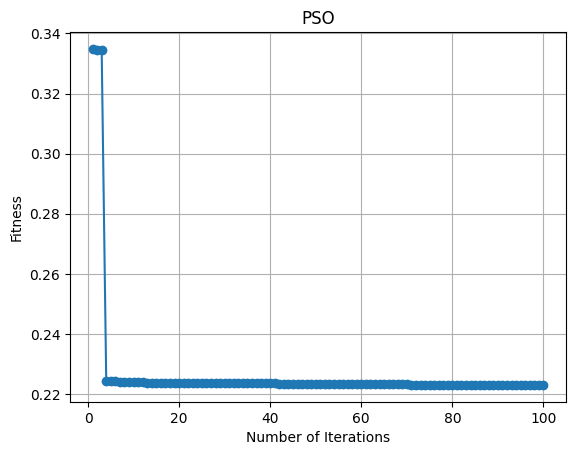

Best parameters found by GridSearchCV:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mean accuracy over all folds: 55.83%
Average Classification Report:
 {
    "0": {
        "precision": 0.5333333333333333,
        "recall": 0.5,
        "f1-score": 0.5031746031746032,
        "support": 4.0
    },
    "1": {
        "precision": 0.5866666666666667,
        "recall": 0.61,
        "f1-score": 0.5886291486291485,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.5599999999999999,
        "recall": 0.5549999999999999,
        "f1-score": 0.5459018759018759,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.5622222222222222,
        "recall": 0.5583333333333333,
        "f1-score": 0.5487445887445888,
        "support": 8.6
    }
}


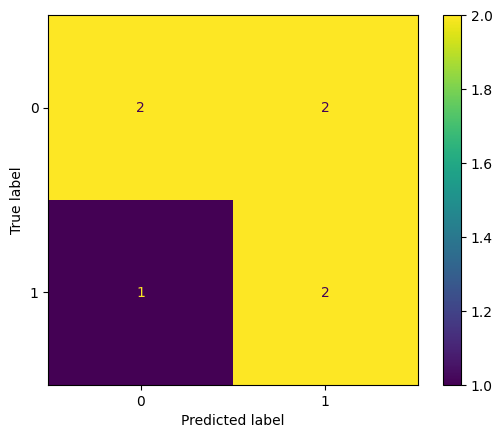

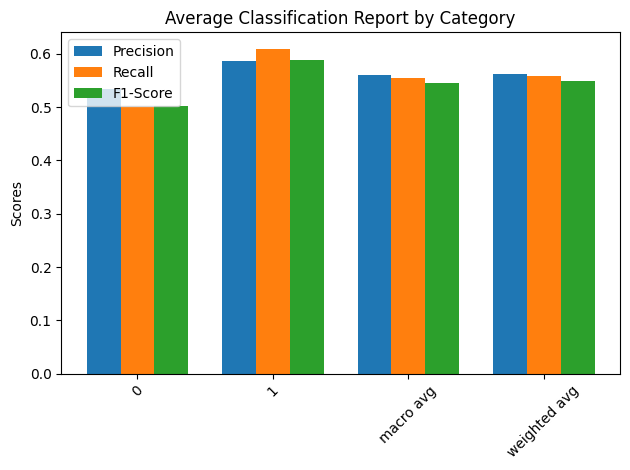

55.83333333333333

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}

main(features, labels, param_grid, SVC)


# k-Nearest Neighbors (k-NN)

In [ ]:
import warnings

from sklearn.neighbors import KNeighborsClassifier

Iteration: 1, Best (PSO): 0.11451219512195127
Iteration: 2, Best (PSO): 0.11451219512195127
Iteration: 3, Best (PSO): 0.11446646341463419
Iteration: 4, Best (PSO): 0.11414634146341468
Iteration: 5, Best (PSO): 0.11414634146341468
Iteration: 6, Best (PSO): 0.11414634146341468
Iteration: 7, Best (PSO): 0.11414634146341468
Iteration: 8, Best (PSO): 0.11414634146341468
Iteration: 9, Best (PSO): 0.11414634146341468
Iteration: 10, Best (PSO): 0.11414634146341468
Iteration: 11, Best (PSO): 0.11405487804878053
Iteration: 12, Best (PSO): 0.004253048780487809
Iteration: 13, Best (PSO): 0.00408536585365854
Iteration: 14, Best (PSO): 0.00408536585365854
Iteration: 15, Best (PSO): 0.00408536585365854
Iteration: 16, Best (PSO): 0.00408536585365854
Iteration: 17, Best (PSO): 0.00408536585365854
Iteration: 18, Best (PSO): 0.00408536585365854
Iteration: 19, Best (PSO): 0.00408536585365854
Iteration: 20, Best (PSO): 0.00408536585365854
Iteration: 21, Best (PSO): 0.00408536585365854
Iteration: 22, Best (

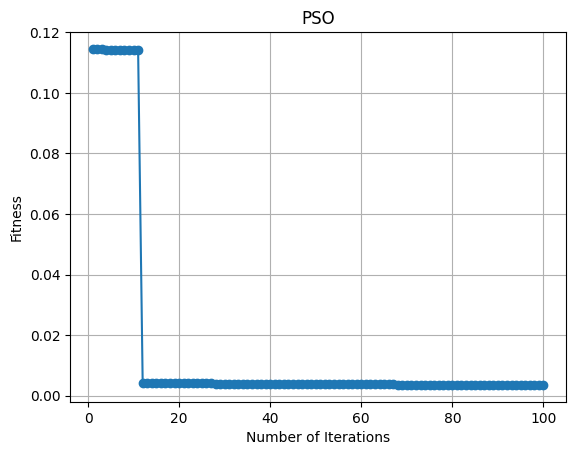

Best parameters found by GridSearchCV:  {'n_neighbors': 5}
Mean accuracy over all folds: 62.78%
Average Classification Report:
 {
    "0": {
        "precision": 0.65,
        "recall": 0.3,
        "f1-score": 0.37666666666666665,
        "support": 4.0
    },
    "1": {
        "precision": 0.6142857142857142,
        "recall": 0.9099999999999999,
        "f1-score": 0.7243589743589743,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6321428571428571,
        "recall": 0.605,
        "f1-score": 0.5505128205128206,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6246031746031746,
        "recall": 0.6277777777777778,
        "f1-score": 0.5624216524216525,
        "support": 8.6
    }
}


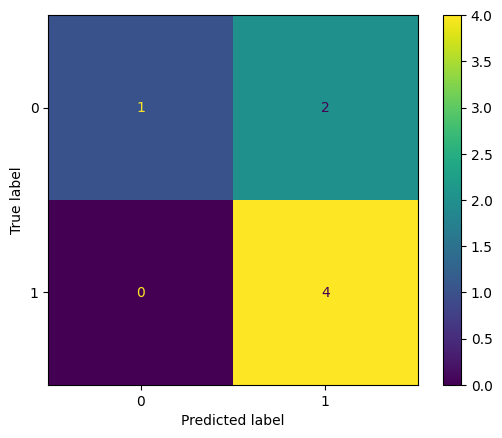

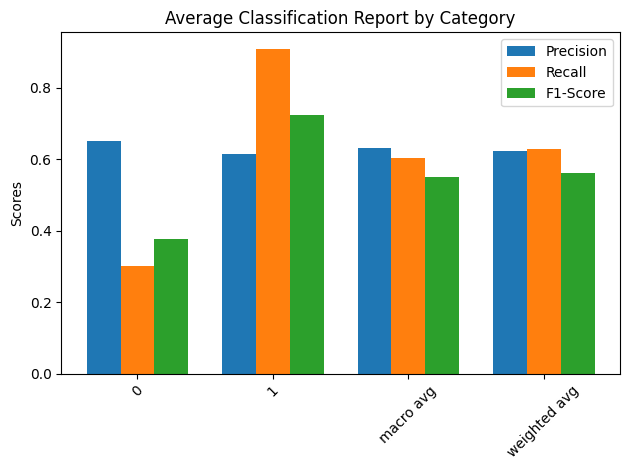

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {"n_neighbors": np.arange(2, 10)}

main(features, labels, param_grid, KNeighborsClassifier)

# Logistic Regression

In [ ]:
import warnings

from sklearn.linear_model import LogisticRegression

Iteration: 1, Best (PSO): 0.11467987804878053
Iteration: 2, Best (PSO): 0.11454268292682931
Iteration: 3, Best (PSO): 0.11432926829268297
Iteration: 4, Best (PSO): 0.004527439024390248
Iteration: 5, Best (PSO): 0.0043597560975609795
Iteration: 6, Best (PSO): 0.0043597560975609795
Iteration: 7, Best (PSO): 0.00422256097560976
Iteration: 8, Best (PSO): 0.004054878048780491
Iteration: 9, Best (PSO): 0.004054878048780491
Iteration: 10, Best (PSO): 0.004054878048780491
Iteration: 11, Best (PSO): 0.004054878048780491
Iteration: 12, Best (PSO): 0.004054878048780491
Iteration: 13, Best (PSO): 0.004054878048780491
Iteration: 14, Best (PSO): 0.004054878048780491
Iteration: 15, Best (PSO): 0.004054878048780491
Iteration: 16, Best (PSO): 0.004054878048780491
Iteration: 17, Best (PSO): 0.004054878048780491
Iteration: 18, Best (PSO): 0.004054878048780491
Iteration: 19, Best (PSO): 0.004054878048780491
Iteration: 20, Best (PSO): 0.004054878048780491
Iteration: 21, Best (PSO): 0.004054878048780491
Ite

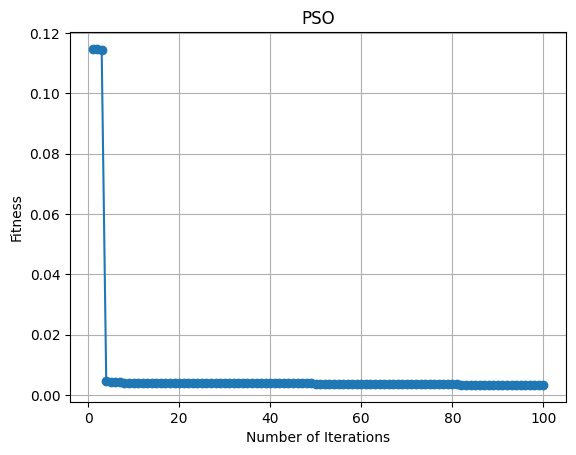

Best parameters found by GridSearchCV:  {'C': 1, 'solver': 'lbfgs'}
Mean accuracy over all folds: 78.61%
Average Classification Report:
 {
    "0": {
        "precision": 0.8266666666666665,
        "recall": 0.75,
        "f1-score": 0.7568253968253967,
        "support": 4.0
    },
    "1": {
        "precision": 0.8200000000000001,
        "recall": 0.8300000000000001,
        "f1-score": 0.8029292929292928,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.8233333333333335,
        "recall": 0.79,
        "f1-score": 0.7798773448773448,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.8274074074074074,
        "recall": 0.7861111111111111,
        "f1-score": 0.7798989898989899,
        "support": 8.6
    }
}


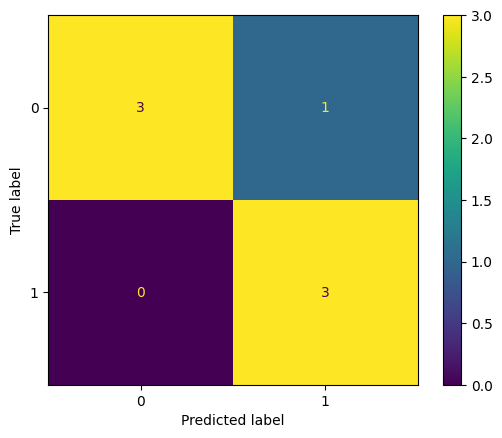

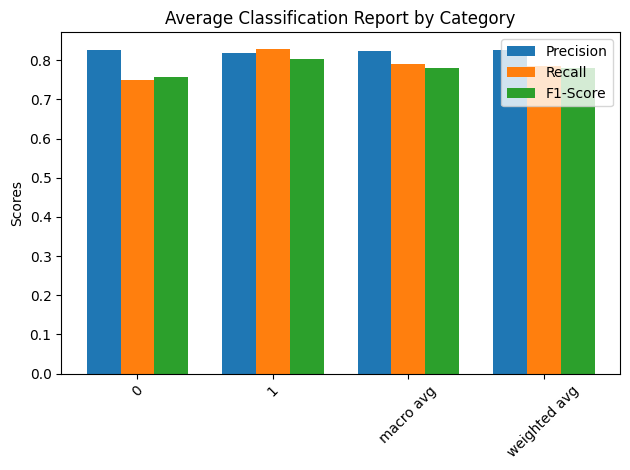

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {"C": [0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "liblinear"]}

main(features, labels, param_grid, LogisticRegression)

# Decision Trees

In [ ]:
import warnings

from sklearn.tree import DecisionTreeClassifier

Iteration: 1, Best (PSO): 0.11500000000000005
Iteration: 2, Best (PSO): 0.11500000000000005
Iteration: 3, Best (PSO): 0.11500000000000005
Iteration: 4, Best (PSO): 0.11500000000000005
Iteration: 5, Best (PSO): 0.11500000000000005
Iteration: 6, Best (PSO): 0.11500000000000005
Iteration: 7, Best (PSO): 0.11500000000000005
Iteration: 8, Best (PSO): 0.11467987804878053
Iteration: 9, Best (PSO): 0.11460365853658541
Iteration: 10, Best (PSO): 0.11460365853658541
Iteration: 11, Best (PSO): 0.11460365853658541
Iteration: 12, Best (PSO): 0.11460365853658541
Iteration: 13, Best (PSO): 0.11460365853658541
Iteration: 14, Best (PSO): 0.11460365853658541
Iteration: 15, Best (PSO): 0.11460365853658541
Iteration: 16, Best (PSO): 0.11460365853658541
Iteration: 17, Best (PSO): 0.11460365853658541
Iteration: 18, Best (PSO): 0.11460365853658541
Iteration: 19, Best (PSO): 0.11460365853658541
Iteration: 20, Best (PSO): 0.11460365853658541
Iteration: 21, Best (PSO): 0.11460365853658541
Iteration: 22, Best (P

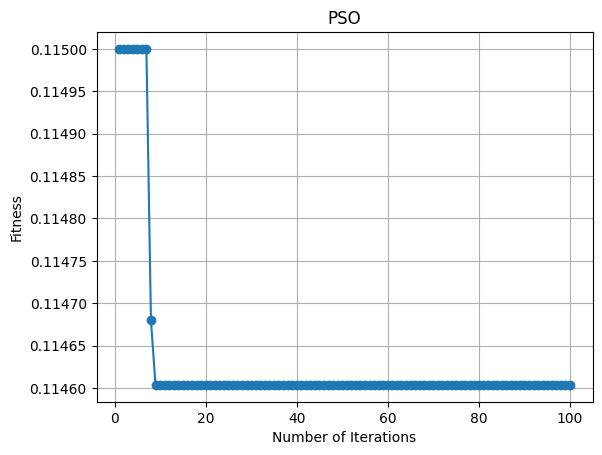

Best parameters found by GridSearchCV:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Mean accuracy over all folds: 53.33%
Average Classification Report:
 {
    "0": {
        "precision": 0.5523809523809524,
        "recall": 0.5,
        "f1-score": 0.48623376623376624,
        "support": 4.0
    },
    "1": {
        "precision": 0.5428571428571429,
        "recall": 0.5599999999999999,
        "f1-score": 0.5195670995670996,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.5476190476190477,
        "recall": 0.53,
        "f1-score": 0.502900432900433,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.5470899470899471,
        "recall": 0.5333333333333333,
        "f1-score": 0.5047522847522847,
        "support": 8.6
    }
}


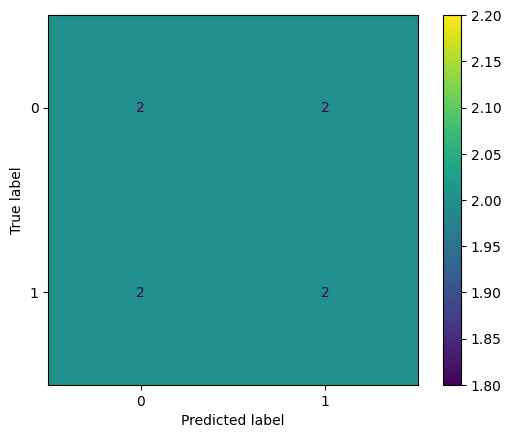

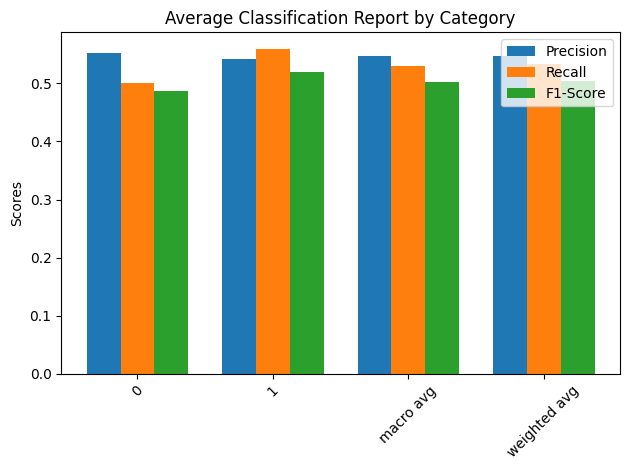

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

main(features, labels, param_grid, DecisionTreeClassifier)

# Random Forest

In [ ]:
import warnings

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Suppress all warnings
warnings.filterwarnings("ignore")

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

main(features, labels, param_grid, RandomForestClassifier)

# XGBoost

In [37]:
import warnings

import xgboost as xgb

Iteration: 1, Best (PSO): 0.44480182926829265
Iteration: 2, Best (PSO): 0.44480182926829265
Iteration: 3, Best (PSO): 0.44472560975609754
Iteration: 4, Best (PSO): 0.44448170731707315
Iteration: 5, Best (PSO): 0.444420731707317
Iteration: 6, Best (PSO): 0.444420731707317
Iteration: 7, Best (PSO): 0.444420731707317
Iteration: 8, Best (PSO): 0.444420731707317
Iteration: 9, Best (PSO): 0.444390243902439
Iteration: 10, Best (PSO): 0.4442835365853658
Iteration: 11, Best (PSO): 0.44423780487804876
Iteration: 12, Best (PSO): 0.4441768292682926
Iteration: 13, Best (PSO): 0.4441615853658536
Iteration: 14, Best (PSO): 0.4441615853658536
Iteration: 15, Best (PSO): 0.4441463414634146
Iteration: 16, Best (PSO): 0.4441006097560975
Iteration: 17, Best (PSO): 0.4440701219512195
Iteration: 18, Best (PSO): 0.4440396341463414
Iteration: 19, Best (PSO): 0.4439786585365853
Iteration: 20, Best (PSO): 0.4439786585365853
Iteration: 21, Best (PSO): 0.4439786585365853
Iteration: 22, Best (PSO): 0.44397865853658

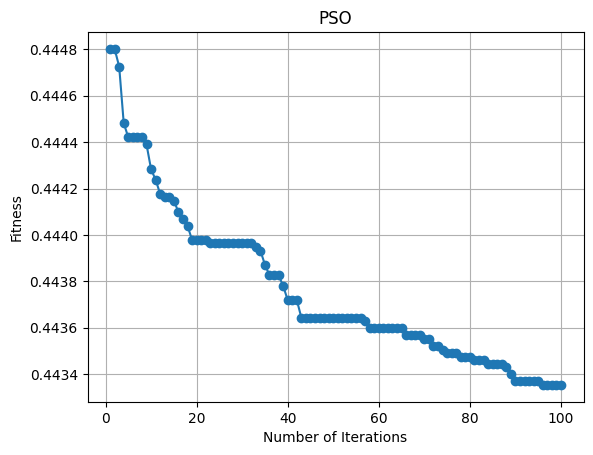

Best parameters found by GridSearchCV:  {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean accuracy over all folds: 67.78%
Average Classification Report:
 {
    "0": {
        "precision": 0.7166666666666666,
        "recall": 0.65,
        "f1-score": 0.6452380952380953,
        "support": 4.0
    },
    "1": {
        "precision": 0.7499999999999999,
        "recall": 0.71,
        "f1-score": 0.6675757575757576,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.7333333333333332,
        "recall": 0.6799999999999999,
        "f1-score": 0.6564069264069264,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7388888888888889,
        "recall": 0.6777777777777778,
        "f1-score": 0.6561664261664262,
        "support": 8.6
    }
}


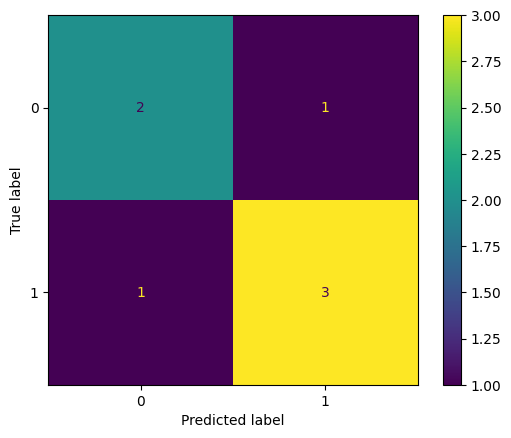

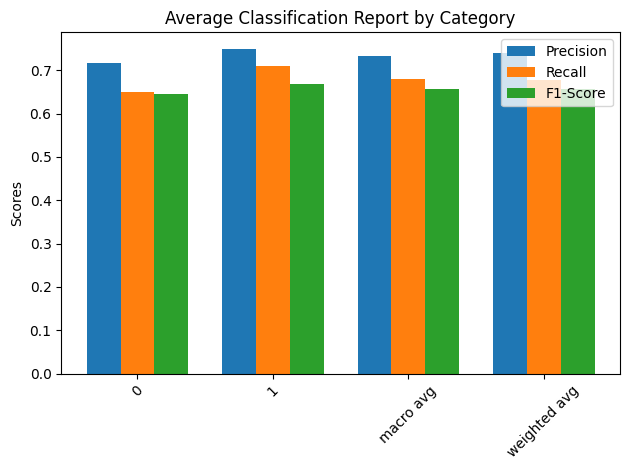

(67.77777777777777,
 ['PRKDC_Missense_Mutation',
  'KLHL6_Missense_Mutation',
  'BCL6_Missense_Mutation',
  'FBXW7_Missense_Mutation',
  'MAP3K1_Missense_Mutation',
  'GABRA6_Missense_Mutation',
  'PIK3CG_Missense_Mutation',
  'PREX2_Missense_Mutation',
  'NTRK2_Missense_Mutation',
  'TET1_Missense_Mutation',
  'WT1_Missense_Mutation',
  'NUTM1_Missense_Mutation',
  'GRIN2A_Missense_Mutation',
  'ANKRD11_Missense_Mutation',
  'BRCA1_Missense_Mutation',
  'RPS6KB1_Missense_Mutation',
  'DNMT1_Missense_Mutation',
  'PAK7_Missense_Mutation',
  'ERG_Missense_Mutation',
  'NF2_Nonsense_Mutation',
  'INSR_Missense_Mutation',
  'SPEN_Missense_Mutation',
  'ARID1A_Missense_Mutation',
  'RANBP2_Missense_Mutation',
  'NSD1_Missense_Mutation',
  'SOX17_Missense_Mutation',
  'FGF19_Missense_Mutation',
  'FLT1_Missense_Mutation',
  'CIC_Missense_Mutation',
  'ARAF_Missense_Mutation',
  'FAT1_Missense_Mutation',
  'RUNX1T1_Missense_Mutation',
  'ROS1_Missense_Mutation',
  'NOTCH4_Missense_Mutation',

In [38]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the model
xgb_model = xgb.XGBClassifier
xgb_model.objective='binary:logistic'

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

main(features, labels, param_grid, xgb_model, data.columns[2:])

# All Info

In [19]:
import warnings

import xgboost as xgb

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

Iteration: 1, Best (PSO): 0.004771341463414638
Iteration: 2, Best (PSO): 0.004314024390243906
Iteration: 3, Best (PSO): 0.004237804878048784
Iteration: 4, Best (PSO): 0.003917682926829272
Iteration: 5, Best (PSO): 0.003917682926829272
Iteration: 6, Best (PSO): 0.003917682926829272
Iteration: 7, Best (PSO): 0.003917682926829272
Iteration: 8, Best (PSO): 0.003917682926829272
Iteration: 9, Best (PSO): 0.003917682926829272
Iteration: 10, Best (PSO): 0.003917682926829272
Iteration: 11, Best (PSO): 0.003917682926829272
Iteration: 12, Best (PSO): 0.003917682926829272
Iteration: 13, Best (PSO): 0.003917682926829272
Iteration: 14, Best (PSO): 0.003917682926829272
Iteration: 15, Best (PSO): 0.003917682926829272
Iteration: 16, Best (PSO): 0.003917682926829272
Iteration: 17, Best (PSO): 0.003917682926829272
Iteration: 18, Best (PSO): 0.003917682926829272
Iteration: 19, Best (PSO): 0.003917682926829272
Iteration: 20, Best (PSO): 0.003917682926829272
Iteration: 21, Best (PSO): 0.003917682926829272
I

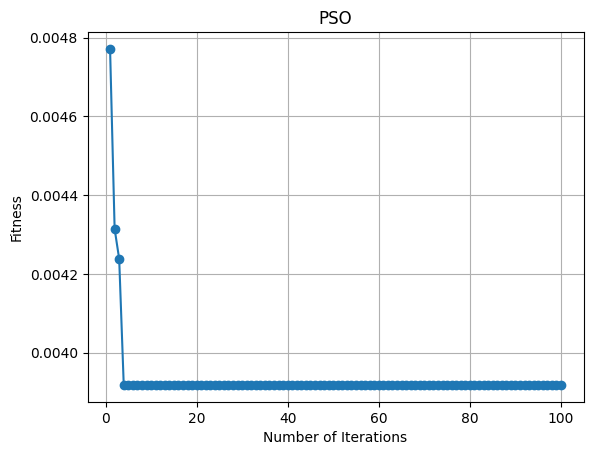

Best parameters found by GridSearchCV:  {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Mean accuracy over all folds: 74.17%
Average Classification Report:
 {
    "0": {
        "precision": 0.7433333333333334,
        "recall": 0.7,
        "f1-score": 0.7134920634920635,
        "support": 4.0
    },
    "1": {
        "precision": 0.7533333333333333,
        "recall": 0.78,
        "f1-score": 0.761010101010101,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.7483333333333333,
        "recall": 0.74,
        "f1-score": 0.7372510822510823,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7511111111111111,
        "recall": 0.7416666666666666,
        "f1-score": 0.7395382395382396,
        "support": 8.6
    }
}


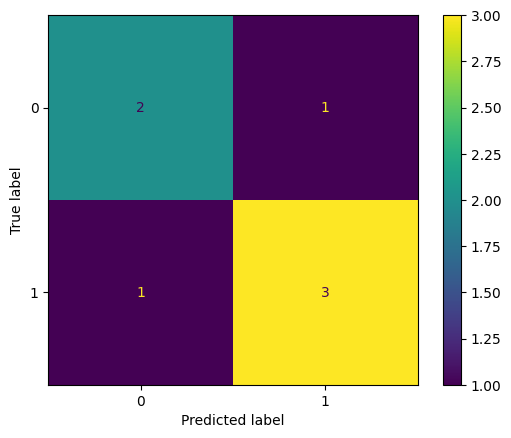

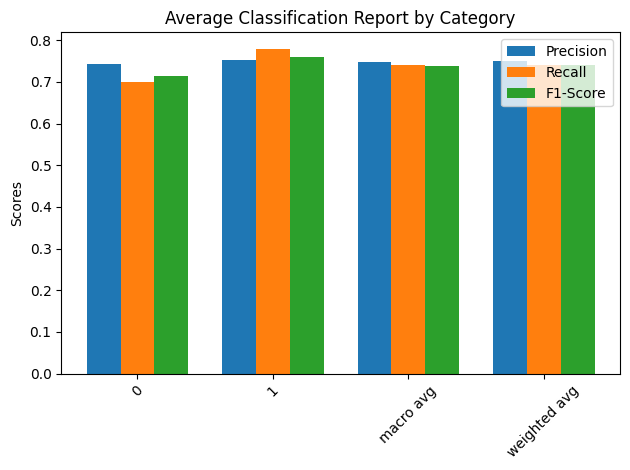

Iteration: 1, Best (PSO): 0.09681863301191157
Iteration: 2, Best (PSO): 0.07378013329551902
Iteration: 3, Best (PSO): 0.07378013329551902
Iteration: 4, Best (PSO): 0.07352098695405561
Iteration: 5, Best (PSO): 0.07352098695405561
Iteration: 6, Best (PSO): 0.07352098695405561
Iteration: 7, Best (PSO): 0.07352098695405561
Iteration: 8, Best (PSO): 0.07352098695405561
Iteration: 9, Best (PSO): 0.07352098695405561
Iteration: 10, Best (PSO): 0.07352098695405561
Iteration: 11, Best (PSO): 0.07352098695405561
Iteration: 12, Best (PSO): 0.07352098695405561
Iteration: 13, Best (PSO): 0.07352098695405561
Iteration: 14, Best (PSO): 0.07352098695405561
Iteration: 15, Best (PSO): 0.07352098695405561
Iteration: 16, Best (PSO): 0.07352098695405561
Iteration: 17, Best (PSO): 0.07352098695405561
Iteration: 18, Best (PSO): 0.050604438457175244
Iteration: 19, Best (PSO): 0.050604438457175244
Iteration: 20, Best (PSO): 0.050604438457175244
Iteration: 21, Best (PSO): 0.050604438457175244
Iteration: 22, Bes

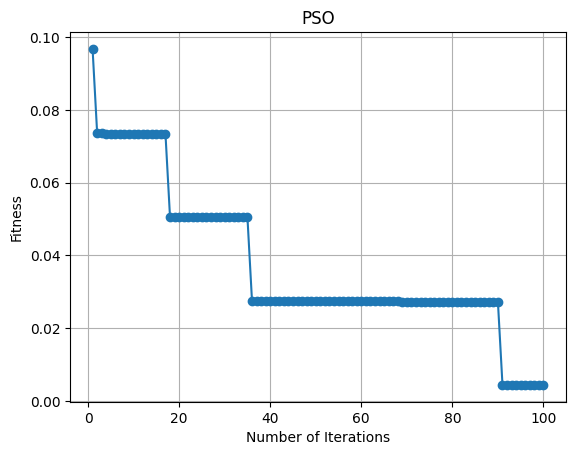

Best parameters found by GridSearchCV:  {'n_neighbors': 8}
Mean accuracy over all folds: 71.94%
Average Classification Report:
 {
    "0": {
        "precision": 0.6957142857142857,
        "recall": 0.9,
        "f1-score": 0.7702020202020201,
        "support": 4.0
    },
    "1": {
        "precision": 0.6599999999999999,
        "recall": 0.55,
        "f1-score": 0.5885714285714286,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6778571428571428,
        "recall": 0.725,
        "f1-score": 0.6793867243867244,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6792063492063491,
        "recall": 0.7194444444444444,
        "f1-score": 0.6770562770562771,
        "support": 8.6
    }
}


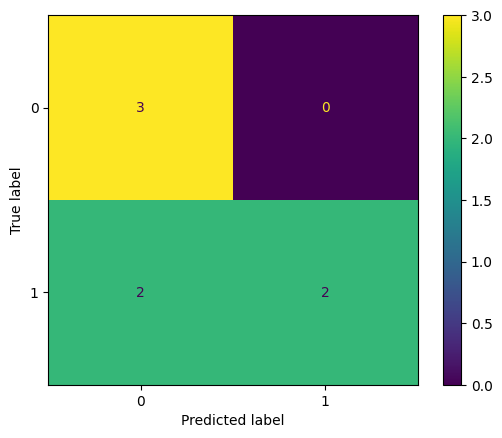

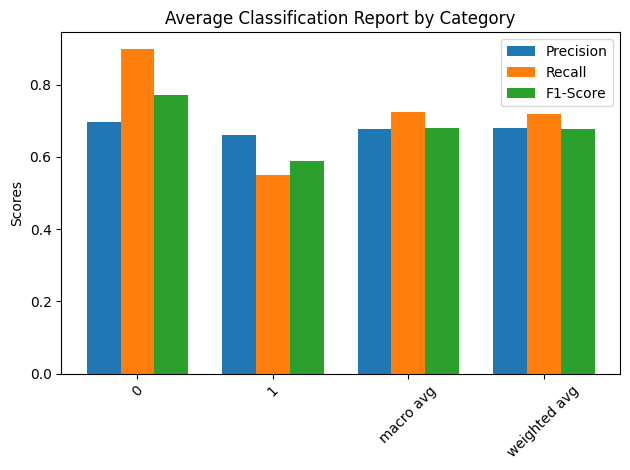

Iteration: 1, Best (PSO): 0.0043597560975609795
Iteration: 2, Best (PSO): 0.0043597560975609795
Iteration: 3, Best (PSO): 0.00408536585365854
Iteration: 4, Best (PSO): 0.003993902439024394
Iteration: 5, Best (PSO): 0.003993902439024394
Iteration: 6, Best (PSO): 0.003978658536585369
Iteration: 7, Best (PSO): 0.003917682926829272
Iteration: 8, Best (PSO): 0.003917682926829272
Iteration: 9, Best (PSO): 0.0039024390243902474
Iteration: 10, Best (PSO): 0.0038414634146341498
Iteration: 11, Best (PSO): 0.003780487804878052
Iteration: 12, Best (PSO): 0.003734756097560979
Iteration: 13, Best (PSO): 0.0036128048780487837
Iteration: 14, Best (PSO): 0.0036128048780487837
Iteration: 15, Best (PSO): 0.0036128048780487837
Iteration: 16, Best (PSO): 0.003582317073170735
Iteration: 17, Best (PSO): 0.003582317073170735
Iteration: 18, Best (PSO): 0.003551829268292686
Iteration: 19, Best (PSO): 0.003551829268292686
Iteration: 20, Best (PSO): 0.003551829268292686
Iteration: 21, Best (PSO): 0.00355182926829

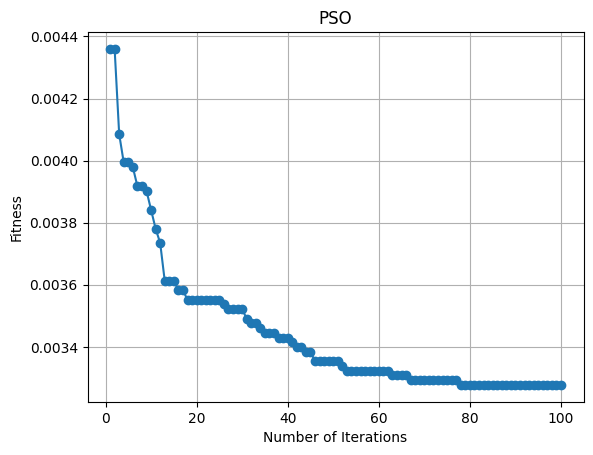

Best parameters found by GridSearchCV:  {'C': 0.1, 'solver': 'liblinear'}
Mean accuracy over all folds: 64.44%
Average Classification Report:
 {
    "0": {
        "precision": 0.6166666666666666,
        "recall": 0.65,
        "f1-score": 0.610952380952381,
        "support": 4.0
    },
    "1": {
        "precision": 0.6933333333333334,
        "recall": 0.64,
        "f1-score": 0.6421212121212122,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.655,
        "recall": 0.645,
        "f1-score": 0.6265367965367966,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6592592592592592,
        "recall": 0.6444444444444445,
        "f1-score": 0.6282683982683983,
        "support": 8.6
    }
}


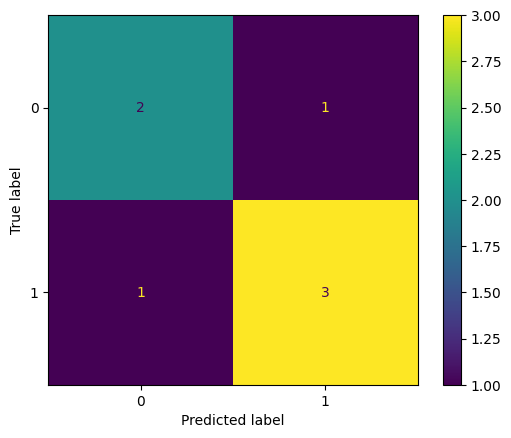

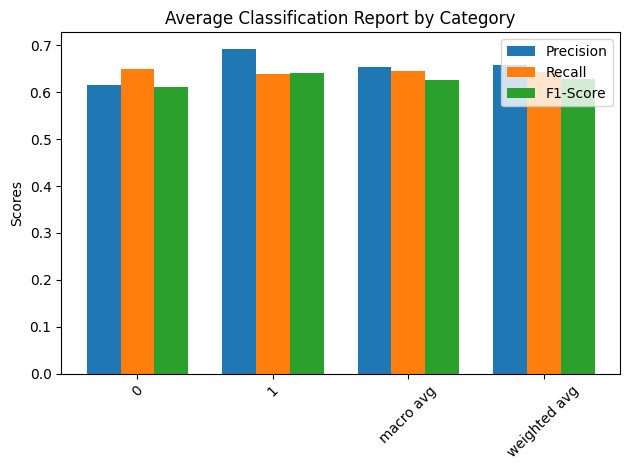

Iteration: 1, Best (PSO): 0.004542682926829272
Iteration: 2, Best (PSO): 0.004375000000000004
Iteration: 3, Best (PSO): 0.004176829268292687
Iteration: 4, Best (PSO): 0.004009146341463418
Iteration: 5, Best (PSO): 0.004009146341463418
Iteration: 6, Best (PSO): 0.003978658536585369
Iteration: 7, Best (PSO): 0.003963414634146345
Iteration: 8, Best (PSO): 0.003963414634146345
Iteration: 9, Best (PSO): 0.003963414634146345
Iteration: 10, Best (PSO): 0.0038719512195121986
Iteration: 11, Best (PSO): 0.0038719512195121986
Iteration: 12, Best (PSO): 0.0038719512195121986
Iteration: 13, Best (PSO): 0.0038719512195121986
Iteration: 14, Best (PSO): 0.0038719512195121986
Iteration: 15, Best (PSO): 0.0038719512195121986
Iteration: 16, Best (PSO): 0.0037195121951219545
Iteration: 17, Best (PSO): 0.0036737804878048813
Iteration: 18, Best (PSO): 0.0036737804878048813
Iteration: 19, Best (PSO): 0.0036737804878048813
Iteration: 20, Best (PSO): 0.0036737804878048813
Iteration: 21, Best (PSO): 0.003673780

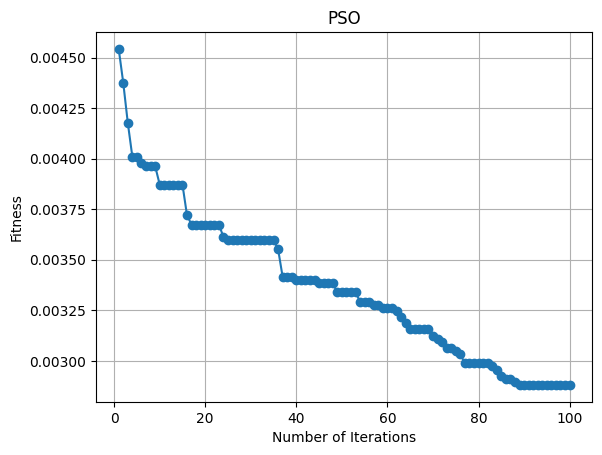

Best parameters found by GridSearchCV:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Mean accuracy over all folds: 60.28%
Average Classification Report:
 {
    "0": {
        "precision": 0.5833333333333333,
        "recall": 0.65,
        "f1-score": 0.6065079365079364,
        "support": 4.0
    },
    "1": {
        "precision": 0.6333333333333333,
        "recall": 0.56,
        "f1-score": 0.5859307359307359,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.6083333333333334,
        "recall": 0.6050000000000001,
        "f1-score": 0.5962193362193362,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.6118518518518519,
        "recall": 0.6027777777777777,
        "f1-score": 0.5968398268398267,
        "support": 8.6
    }
}


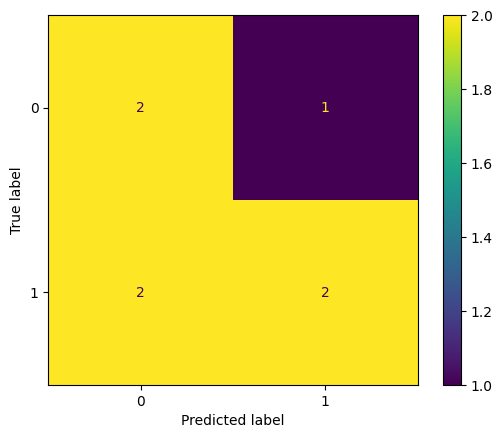

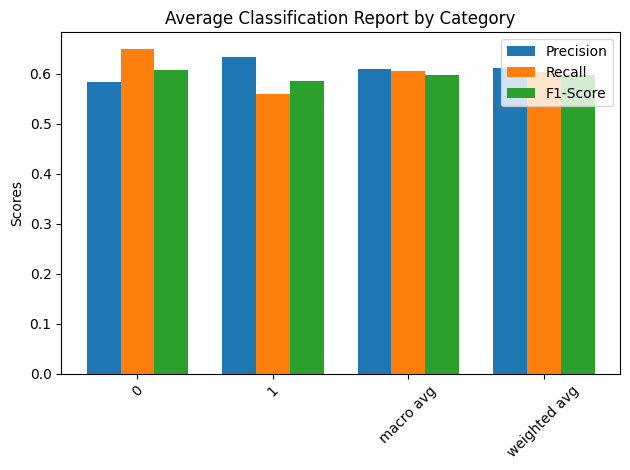

Iteration: 1, Best (PSO): 0.00446646341463415
Iteration: 2, Best (PSO): 0.004298780487804882
Iteration: 3, Best (PSO): 0.004161585365853662
Iteration: 4, Best (PSO): 0.003917682926829272
Iteration: 5, Best (PSO): 0.003917682926829272
Iteration: 6, Best (PSO): 0.0039024390243902474
Iteration: 7, Best (PSO): 0.0038719512195121986
Iteration: 8, Best (PSO): 0.0037500000000000033
Iteration: 9, Best (PSO): 0.0036737804878048813
Iteration: 10, Best (PSO): 0.0035670731707317105
Iteration: 11, Best (PSO): 0.0035213414634146373
Iteration: 12, Best (PSO): 0.003445121951219515
Iteration: 13, Best (PSO): 0.003445121951219515
Iteration: 14, Best (PSO): 0.003445121951219515
Iteration: 15, Best (PSO): 0.003445121951219515
Iteration: 16, Best (PSO): 0.003445121951219515
Iteration: 17, Best (PSO): 0.003445121951219515
Iteration: 18, Best (PSO): 0.003445121951219515
Iteration: 19, Best (PSO): 0.003445121951219515
Iteration: 20, Best (PSO): 0.003445121951219515
Iteration: 21, Best (PSO): 0.003445121951219

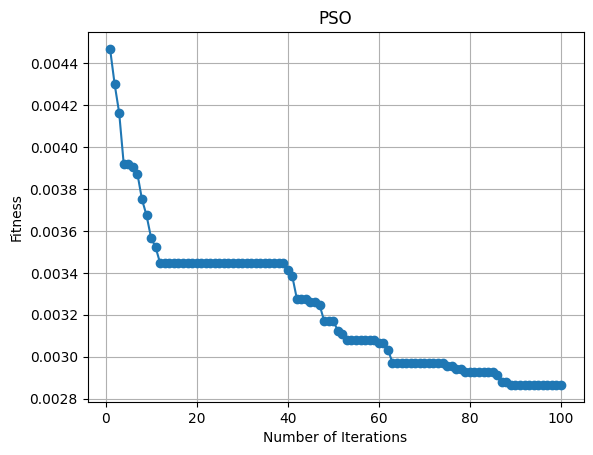

Best parameters found by GridSearchCV:  {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
Mean accuracy over all folds: 68.06%
Average Classification Report:
 {
    "0": {
        "precision": 0.7166666666666666,
        "recall": 0.65,
        "f1-score": 0.6452380952380952,
        "support": 4.0
    },
    "1": {
        "precision": 0.7533333333333332,
        "recall": 0.72,
        "f1-score": 0.6735353535353535,
        "support": 4.6
    },
    "macro avg": {
        "precision": 0.735,
        "recall": 0.6849999999999999,
        "f1-score": 0.6593867243867244,
        "support": 8.6
    },
    "weighted avg": {
        "precision": 0.7429629629629628,
        "recall": 0.6805555555555556,
        "f1-score": 0.6591245791245791,
        "support": 8.6
    }
}


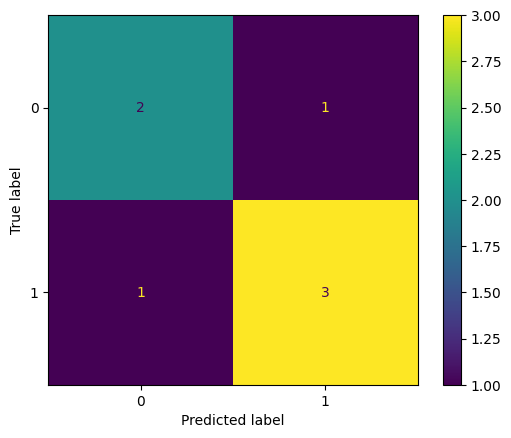

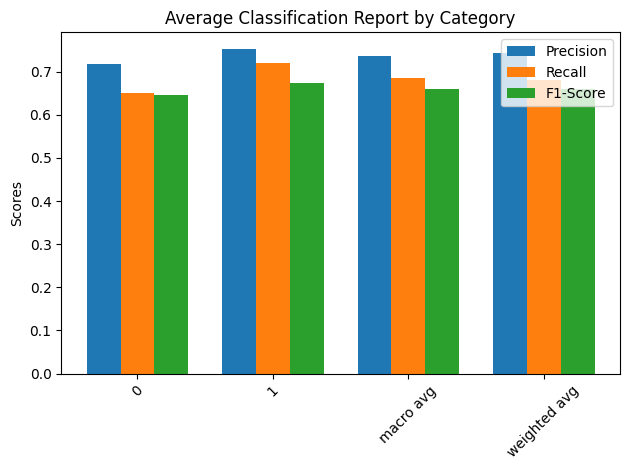

In [20]:
# Suppress all warnings
warnings.filterwarnings("ignore")

plot_results = {}
features_results = {}

param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"],
}

plot_results["SVM"], features_results["SVM"] = main(
    features, labels, param_grid, SVC, data.columns[2:]
)

param_grid = {"n_neighbors": np.arange(2, 10)}

plot_results["KNeighborsClassifier"], features_results["KNeighborsClassifier"] = main(
    features, labels, param_grid, KNeighborsClassifier, data.columns[2:]
)

param_grid = {"C": [0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "liblinear"]}

plot_results["LogisticRegression"], features_results["LogisticRegression"] = main(
    features, labels, param_grid, LogisticRegression, data.columns[2:]
)

param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

plot_results["DecisionTreeClassifier"], features_results["DecisionTreeClassifier"] = (
    main(features, labels, param_grid, DecisionTreeClassifier, data.columns[2:])
)

# Define the model
xgb_model = xgb.XGBClassifier
xgb_model.objective='binary:logistic'

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

plot_results["XGBoost"], features_results["XGBoost"] = (
    main(features, labels, param_grid, xgb_model, data.columns[2:])
)

In [21]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(list(plot_results.items()), columns=['Classifier', 'Accuracy'])

# Save DataFrame to CSV file
df.to_csv('/content/ML_PSO.csv', index=False)


In [22]:
def fix_data_length(data_dict):
    # Find the maximum length of the lists in the dictionary
    max_length = max(len(lst) for lst in data_dict.values())

    # Pad shorter lists with None
    for key, lst in data_dict.items():
        if len(lst) < max_length:
            data_dict[key] = lst + [None] * (max_length - len(lst))

    return data_dict

# Fix the data length
fixed_data = fix_data_length(features_results)

In [23]:
# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame(fixed_data)
df

,SVM,KNeighborsClassifier,LogisticRegression,DecisionTreeClassifier,XGBoost
0,TMB,SPTA1_Missense_Mutation,PGA,TMB,LRP1B_Missense_Mutation
1,PGA,CTLA4_Missense_Mutation,MYCN_Missense_Mutation,SPTA1_Missense_Mutation,BCL6_Missense_Mutation
2,SPTA1_Missense_Mutation,FOXP1_Missense_Mutation,FOXP1_Missense_Mutation,SETD2_Missense_Mutation,GABRA6_Missense_Mutation
3,CSF3R_Missense_Mutation,GABRA6_Missense_Mutation,KLHL6_Missense_Mutation,PRKDC_Missense_Mutation,FGFR4_Missense_Mutation
4,LRP1B_Missense_Mutation,PIK3CG_Missense_Mutation,SLIT2_Missense_Mutation,CSF3R_Missense_Mutation,PRDM1_Missense_Mutation
...,...,...,...,...,...
282,None,AR_logCR,None,None,None
283,None,PAK3_logCR,None,None,None
284,None,XIAP_logCR,None,None,None
285,None,STAG2_logCR,None,None,None


In [27]:
# Extracting common features in all classifiers
common_features = set(df['SVM'])

for column in df.columns[1:]:
    common_features.intersection_update(df[column])

# Converting the set to a sorted list for better readability
common_features = sorted(list(common_features))

common_features = common_features + [None] * (284)

# Print the common features
print(common_features)

['MEF2B_logCR', 'PPARG_Missense_Mutation', 'TFRC_logCR', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, N

In [28]:
len(common_features)

287

In [29]:
# Using DataFrame.insert() to add a column
df.insert(2, "Common_Features", common_features, True)

# Observe the result
print(df)

                         SVM      KNeighborsClassifier  \
0                        TMB   SPTA1_Missense_Mutation   
1                        PGA   CTLA4_Missense_Mutation   
2    SPTA1_Missense_Mutation   FOXP1_Missense_Mutation   
3    CSF3R_Missense_Mutation  GABRA6_Missense_Mutation   
4    LRP1B_Missense_Mutation  PIK3CG_Missense_Mutation   
..                       ...                       ...   
282                     None                  AR_logCR   
283                     None                PAK3_logCR   
284                     None                XIAP_logCR   
285                     None               STAG2_logCR   
286                     None                PHF6_logCR   

             Common_Features       LogisticRegression  \
0                MEF2B_logCR                      PGA   
1    PPARG_Missense_Mutation   MYCN_Missense_Mutation   
2                 TFRC_logCR  FOXP1_Missense_Mutation   
3                       None  KLHL6_Missense_Mutation   
4                 

In [30]:
# Save DataFrame to CSV file
df.to_csv('/content/ML_PSO_features.csv', index=False)